In [1]:
import os
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout, LayerNormalization, MultiHeadAttention
from keras.optimizers import SGD

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

2024-04-07 16:38:04.892085: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 16:38:05.608717: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/user/.local/lib/python3.10/site-packages/nvidia/cudnn/lib/:/usr/local/lib:/usr/local/cuda-12.1/lib64
2024-04-07 16:38:05.608791: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/user/.local/lib/p

In [2]:
PATH = "/home/user/repos/DL1"
PATH_TRAIN  = PATH + "/DATASET/train"
PATH_TEST   = PATH + "/DATASET/test"
PATH_VALID  = PATH + "/DATASET/valid"
PATH_MODELS = PATH + "/MODELS/"

In [11]:
IMAGE_SIZE = (32, 32)
INPUT_SHAPE = (32, 32, 3)
BATCH_SIZE = 128
NUM_CLASSES = 10
EPOCHS = 5
SEED = 69
DEFAULT_OPTIMIZER = 'adam'
DEFAULT_LOSS = 'categorical_crossentropy'

In [4]:
test_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
)
test_generator = test_datagen.flow_from_directory(
    PATH_TEST,
    seed=SEED,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.


In [7]:
model_names = [
    'ACC047_0-3MPARAMS_VIT_DROP01_AUG_NADAM_EPOCH5.tf',
    'ACC054_0-4MPARAMS_REX_NODROP_AUG_NADAM_EPOCH5.tf',
    'ACC056_2-5MPARAMS_CNN_DROP03_AUG_NADAM_EPOCH5.tf',
    'ACC058_2-5MPARAMS_CNN_NODROP_AUG_NADAM_EPOCH5.tf',
    'ACC063_0-7MPARAMS_RES_NODROP_AUG_NADAM_EPOCH5.tf',
    'ACC064_1-3MPARAMS_VGG_NODROP_AUG_NADAM_EPOCH5.tf',
    'ACC065_2-7MPARAMS_RES_NODROP_AUG_NADAM_EPOCH5.tf'
]

models = [tf.keras.models.load_model(PATH_MODELS + model_name) for model_name in model_names]

1/1 [==============================] - 4s 4s/step


2024-04-07 16:44:14.886407: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700


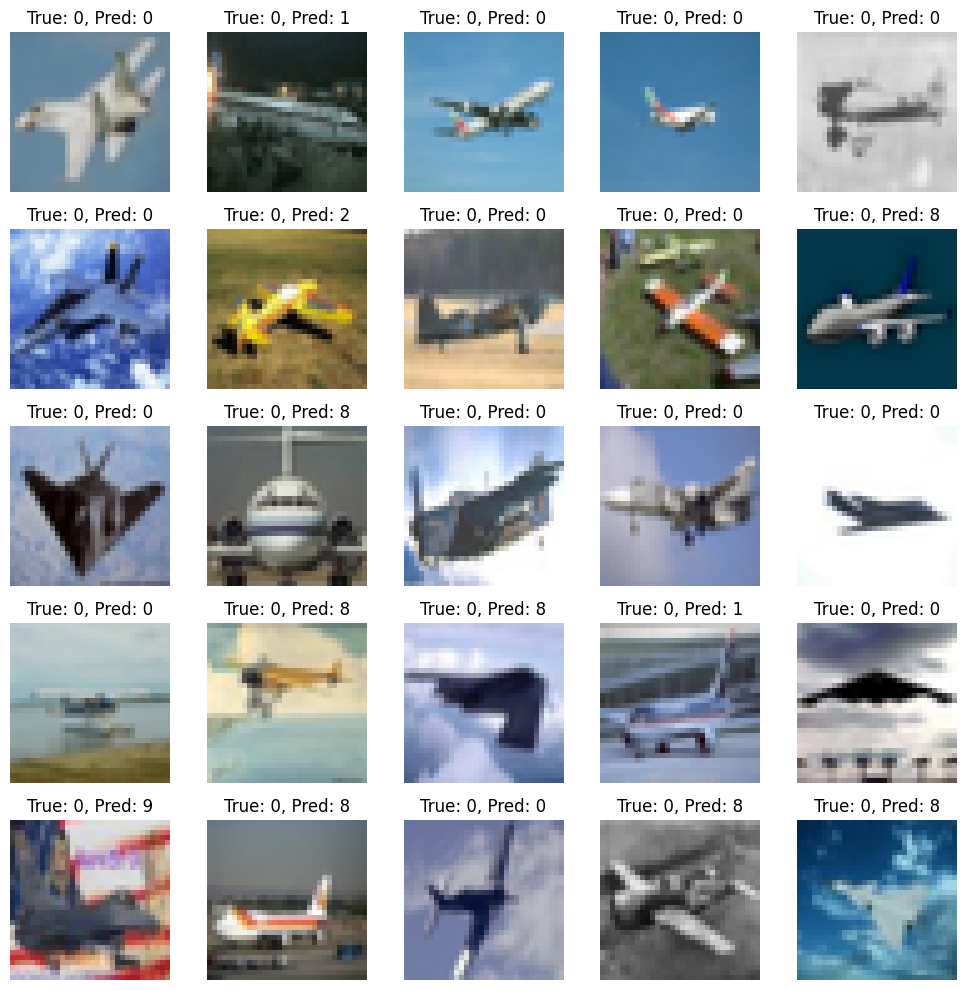

In [8]:
batch = next(test_generator)

# Extract images and labels from the batch
images, labels = batch

# Make predictions on the images
predictions = models[0].predict(images)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Display the examples along with their true and predicted labels
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
axes = axes.flatten()

for i, (image, true_label, predicted_label) in enumerate(zip(images, labels, predicted_labels)):
    if i >= 25:
        break
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(f"True: {np.argmax(true_label)}, Pred: {predicted_label}")

plt.tight_layout()
plt.show()

In [ ]:
# SINGLE
MODEL_INDEX = 0
test_generator.reset()
predictions = models[MODEL_INDEX].predict(test_generator)

true_labels = test_generator.classes

conf_matrix = confusion_matrix(true_labels, np.argmax(predictions, axis=1))

In [9]:
# ENSEMBLE
predictions = []
for model in models:
    predictions.append(model.predict(test_generator))


2813/2813 [==============================] - 42s 15ms/step
Ensemble Accuracy: 0.6858888888888889


In [ ]:
# AVERAGING
ensemble_predictions = np.mean(predictions, axis=0)

predicted_classes = np.argmax(ensemble_predictions, axis=1)

true_labels = test_generator.classes

accuracy = np.mean(predicted_classes == true_labels)
print("Ensemble Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_classes)

In [13]:
# VOTING
ensemble_predictions = []
for sample_predictions in zip(*predictions):
    counts = [0] * NUM_CLASSES 
    for pred in sample_predictions:
        counts[np.argmax(pred)] += 1  
    ensemble_predictions.append(np.argmax(counts)) 

ensemble_predictions = np.array(ensemble_predictions)

accuracy = np.mean(ensemble_predictions == true_labels)
print("Ensemble Accuracy:", accuracy)

conf_matrix = confusion_matrix(true_labels, ensemble_predictions)

Ensemble Accuracy: 0.6698333333333333


Accuracy: 0.6698333333333333


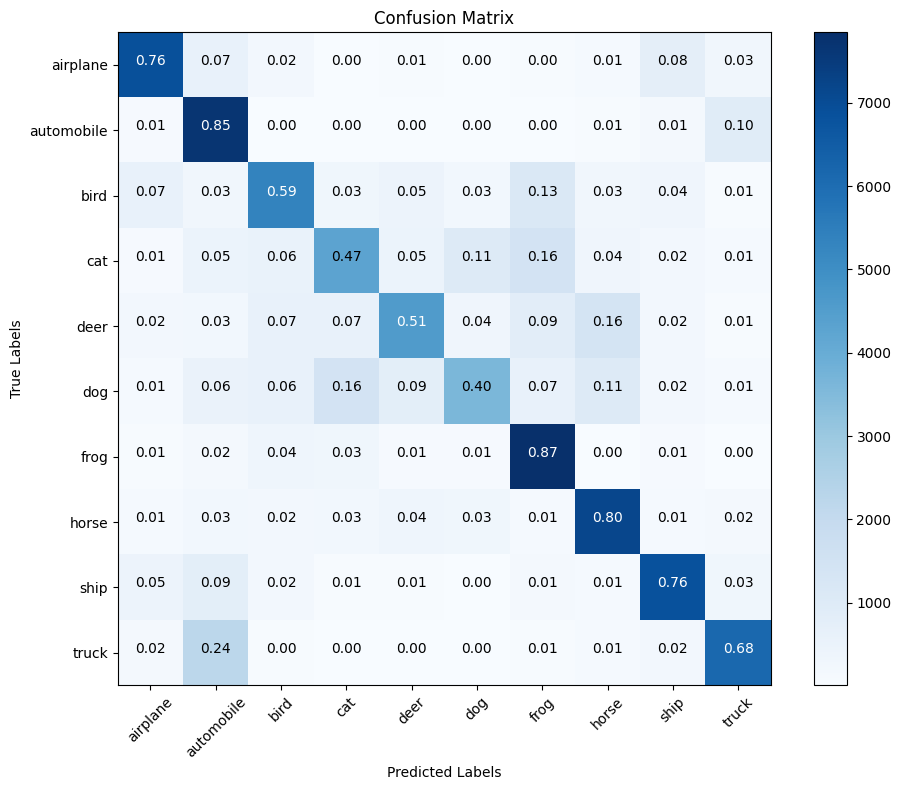

In [14]:
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print("Accuracy:", accuracy)

class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

num_classes = len(conf_matrix)
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, f'{conf_matrix[i, j] / np.sum(conf_matrix[i]):.2f}', horizontalalignment="center", 
                 color="black" if conf_matrix[i, j] < np.sum(conf_matrix[i]) * 0.5 else "white")
        
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()

plt.show()
